Shape of loaded binary matrix: (50, 350)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Total number of notes on: 469
Note density: 0.0268


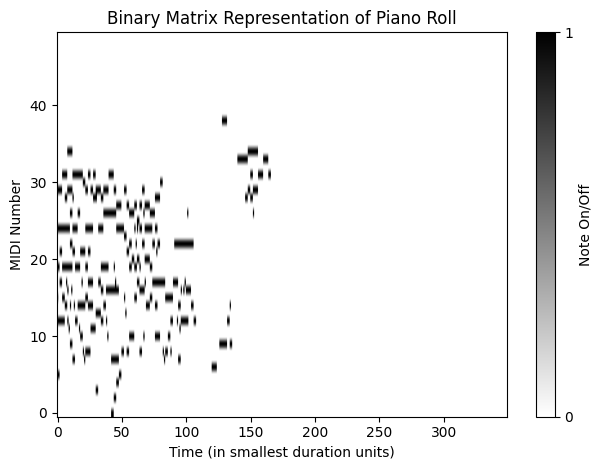

In [39]:
import numpy as np

# Load the binary matrix from the file
binary_matrix = np.load('binary_image_1.npy')

# Now you can use binary_matrix as a regular NumPy array
# For instance, you can print its shape or its content
print(f'Shape of loaded binary matrix: {binary_matrix.shape}')
print(binary_matrix)

# You can also perform any operations on the matrix
# For example, let's find the sum of all elements (which will give us the total number of notes on)
total_notes_on = np.sum(binary_matrix)
print(f'Total number of notes on: {total_notes_on}')


# Or you could use it as part of a function, for example to calculate the density of notes
def note_density(binary_matrix):
    return np.sum(binary_matrix) / np.size(binary_matrix)

density = note_density(binary_matrix)
print(f'Note density: {density}')

# And you can use it in plotting or any further analysis
# Example: Visualizing the transposed matrix using matplotlib
import matplotlib.pyplot as plt

plt.imshow(binary_matrix, aspect='auto', origin='lower', cmap='gray_r')
plt.ylabel('MIDI Number')
plt.xlabel('Time (in smallest duration units)')
plt.title('Binary Matrix Representation of Piano Roll')
plt.colorbar(label='Note On/Off', ticks=[0, 1])
plt.tight_layout()
plt.show()


In [40]:
import numpy as np
import mido
from mido import MidiFile, MidiTrack, Message

# Define the smallest duration unit in milliseconds (e.g., 100ms)
smallest_duration_ms = 400

# Define the lowest pitch as MIDI note number (e.g., 21 for a standard piano's lowest A)
lowest_midi_pitch = 51

# Create a new MIDI file with one track
mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)

# Add tempo meta message to the track (500000 is the default tempo for mido, which is 120 bpm)
track.append(mido.MetaMessage('set_tempo', tempo=500000))

# Initialize an array to keep track of the state (on/off) of each note
note_states = np.zeros(binary_matrix.shape[0], dtype=int)
# Calculate time in ticks for the smallest duration unit
time_in_ticks = mido.second2tick(smallest_duration_ms / 1000, mid.ticks_per_beat, mido.bpm2tempo(120))

# Initialize a variable to keep track of the time since the last event
time_since_last_event = 0

# Iterate over the columns/time steps of the binary matrix
for col_index in range(binary_matrix.shape[1]):
    # Iterate over each row/note in the column
    for row_index, value in enumerate(binary_matrix[:, col_index]):
        note = lowest_midi_pitch + row_index
        if value == 1 and note_states[row_index] == 0:
            # Note on
            track.append(Message('note_on', note=note, velocity=64, time=int(time_since_last_event)))
            note_states[row_index] = 1
            time_since_last_event = 0
        elif value == 0 and note_states[row_index] == 1:
            # Note off
            track.append(Message('note_off', note=note, velocity=64, time=int(time_since_last_event)))
            note_states[row_index] = 0
            time_since_last_event = 0

    # Increment time since the last event
    time_since_last_event += time_in_ticks

# Turn off any notes that are still on
for row_index, state in enumerate(note_states):
    if state == 1:
        note = lowest_midi_pitch + row_index
        track.append(Message('note_off', note=note, velocity=64, time=int(time_since_last_event)))

# Save the MIDI file
mid.save('output_14.mid')
